$$\textbf{Machine Learning. Tarea 7: Pix2Pix}$$
$$\textit{Y. Sarahi García Gozález}$$

<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [33]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import sklearn as sk
import scipy as sp
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import time
import datetime

In [3]:
print("Tarea realizada en Kaggle. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE") 


Tarea realizada en Kaggle. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.10.13
NumPy version: 1.26.4
Tensor Flow Version: 2.15.0
Scikit-Learn 1.2.2
SciPy 1.11.4
GPU is available


In [4]:
len(tf.config.list_physical_devices('GPU'))

2

<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de los datos}$

Descargué los datos y para cargar los mapas de prfundidad utilicé la libreria read_depht que proporciona la página de donde obtuvimos el dataset

In [5]:
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(float) / 256.
    depth[depth_png == 0] = -1.
    return depth

In [6]:
def load_data(datos_phat):
    #listas vacias para almacenar las imagenes y los mapas de profundidad
    images = []
    depth_maps = []
    #creamos un lista con los directorios que se encuentra dentro de la carpeta "datos"
    directorios = os.listdir(datos_phat)
    for directorio in directorios: #iteramos sobre éstos 

        #si dentro de "datos" se encuentra un archivo .DS_Store, lo ignoramos (esto pasa en sistema MacOs)
        if directorio=='.DS_Store':
            continue

        #guardamos ruta de directorio imagenes
        image_directorio = os.path.join(datos_phat, directorio, "image")
        #guardamos ruta de directorio mapas de profundidad
        depth_map_directorio = os.path.join(datos_phat, directorio, "groundtruth_depth")

        #creamos una lista de los archivos dentro del directorio imagenes
        image_files = os.listdir(image_directorio)
        #creamos una lista de los archivos dentro del directorio mapas d profundudad
        depth_map_files = os.listdir(depth_map_directorio)

        #iteramos sobre las listas anteriores 
        for image_file, depth_map_file in zip(image_files, depth_map_files):
            #creamos la ruta completa de la imagen actual
            image_path = os.path.join(image_directorio, image_file)
            #leemos
            image = cv2.imread(image_path)
            #ajutamo la escala
            image = cv2.resize(image,(224, 224) )

            #creamos la ruta completa del mapa actual
            depth_map_path = os.path.join(depth_map_directorio, depth_map_file)
            #leemos
            depth_map = depth_read(depth_map_path)
            depth_map =  cv2.resize(depth_map, (224, 224))

            #agregmos la imagen y el mapa actuales a las listas correspondiente
            images.append(image)
            depth_maps.append(depth_map)

    return np.array(images), np.array(depth_maps)

In [8]:
#cargamos los datos usando la funcion load data
path = "/kaggle/input/kitti-data-set/datos"
X, y = load_data(path)

Aumentemos el numero de imagenenes en el conjunto  X y y

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotación aleatoria en grados, reducida a 10
    width_shift_range=0.05, # Desplazamiento horizontal aleatorio, reducido a 0.05
    height_shift_range=0.05,# Desplazamiento vertical aleatorio, reducido a 0.05
    shear_range=0.1,        # Intensidad de la deformación de cizalla, reducida a 0.1
    zoom_range=0.1,         # Rango de zoom aleatorio, reducido a 0.1
    horizontal_flip=True,   # Volteo horizontal aleatorio
    fill_mode='nearest'     # Modo de relleno para los píxeles fuera de los límites de la imagen original
)

batch_size = 32 # Reducir el tamaño del batch para menor carga de memoria
num_augmented_images = 500  # Número de imágenes a generar
num_batches = num_augmented_images // batch_size

# Listas vacías para datos aumentados
X_aumentado = []
y_aumentado = []

# Recolectamos las imágenes aumentadas en lotes
for batch in range(num_batches):
    # Generamos un lote de imágenes aumentadas y etiquetas correspondientes
    augmented_data = next(datagen.flow(X, y, batch_size=batch_size, shuffle=False))
    # Extraemos las imágenes y las etiquetas
    X_batch_augmented, y_batch_augmented = augmented_data
    # Las agregamos a los conjuntos correspondientes
    X_aumentado.append(X_batch_augmented)
    y_aumentado.append(y_batch_augmented)

# Convertimos la lista de lotes de imágenes aumentadas en un único conjunto
X_aumentado = np.concatenate(X_aumentado, axis=0)
y_aumentado = np.concatenate(y_aumentado, axis=0)

Ahora concatenamos las imágenes y mapas aumentados con los conjuntosoriginales

In [10]:
X = np.concatenate([X, X_aumentado], axis=0)

In [ ]:
np.shape(X)

(2480, 224, 224, 3)

In [12]:
y = np.concatenate([y, y_aumentado], axis=0)

In [13]:
np.shape(y)

(2480, 224, 224)

Se pide:
* Entrada: imágenes rgb+ en 224x224 pixéles
* Salida: imágenes escala de gris codificando profundidad en 224x224 pixeles

In [14]:
print("Shape of images X:", X.shape)
print("Shape of depth maps y:", y.shape)

Shape of images X: (2480, 224, 224, 3)
Shape of depth maps y: (2480, 224, 224)


In [15]:
X = X.astype('float32') / 255.0

Dividimos en entrenamiento 80% y prueba 20%

In [16]:
#Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1984, 224, 224, 3)
Shape of y_train: (1984, 224, 224)
Shape of X_test: (496, 224, 224, 3)
Shape of y_test: (496, 224, 224)


In [17]:
# Convertir las imágenes de entrada y las etiquetas a float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Expandir la dimensión de las etiquetas para tener un canal adicional
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

# Crear datasets de TensorFlow a partir de los tensores
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1600).batch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

(-0.5, 223.5, 223.5, -0.5)

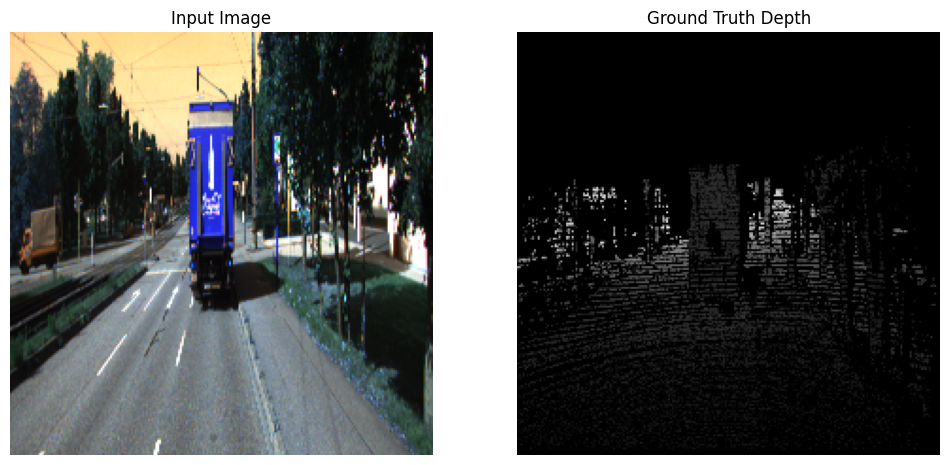

In [19]:
ejem=1 #ejemplo imagen aumentada
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_train[ejem])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[ejem], cmap='gray')
plt.title('Ground Truth Depth')
plt.axis('off')

<font size=4 color='mediumslateblue'>  

$\textit{Arquitecturas}$

In [20]:
#https://keras.io/examples/vision/oxford_pets_image_segmentation/


def get_unet(trainable):
    # Ruta de los pesos de VGG16
    weights_path = '/Users/ely/Documents/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    # Imágenes RGB de 224x224 pixeles para la entrada
    img_size = (224, 224, 3)  

    # Usamos VGG16 con los pesos preentrenados, solo la etapa de extracción de características, y input de 224x224 RGB
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=img_size)
    conv_base.trainable = trainable

    # Codificador
    encoder_output = conv_base.get_layer("block5_pool").output

    # Decodificador
    
    # Entry block
    x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(encoder_output)
    x = layers.Concatenate()([x, conv_base.get_layer("block5_conv3").output])
    #  Block 2
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block4_conv3").output])
    #  Block 3
    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block3_conv3").output])
    #  Block 4
    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, conv_base.get_layer("block2_conv2").output])

    #Salida de una sola canal con sigmoid como activacion
    x = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)

    #Definimos el modelo
    model = tf.keras.Model(inputs=conv_base.input, outputs=x)

    return model

#construimos genrador 
generator = get_unet(False)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 19,206,945 (73.27 MB)

 Trainable params: 4,492,257 (17.14 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
####el discriminador en la arquitectura pix2pix intenta
#### distinguir entre imágenes reales (en este caso de profundidad) 
#### y las generadas por la red generadora (en este caso la UNET)
### Para hacerlo, utiliza una serie de capas convolucionales que procesan las imágenes 
### de entrada y emiten una predicción sobre si la imagen de profundidad es real o generada



def get_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # Entrada de la imagen RGB (224, 224, 3)
    inp = layers.Input(shape=[224, 224, 3], name='input_image')
    # Entrada de la imagen de profundidad (224, 224, 1)
    tar = layers.Input(shape=[224, 224, 1], name='target_image')
    # Concatenar las imágenes 
    x = layers.concatenate([inp, tar])  # (bs, 224, 224, 4)

    #En las siguientes capas convolucionales usaremos como activacion LeakyReLU
    #Esta funcion introduce no linealidad en la red 
    # ayuda a evitar que las unidades queden completamente inactiva
    #capa conv1
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)
    #capa conv2
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    #capa conv3
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    #capa conv4
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x= layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=x)

#construimos genrador 
discriminator = get_discriminator()
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 224, 224,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 4)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      4,160 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 56, 56,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │    524,544 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 30, 30,    │          0 │ leaky_re_lu_2[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 27, 27,    │  2,097,664 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 27,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 27, 27,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 29, 29,    │          0 │ leaky_re_lu_3[0]… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 26, 26, 1) │      8,193 │ zero_padding2d_1

 Total params: 2,769,345 (10.56 MB)

 Trainable params: 2,767,553 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

<font size=4 color='mediumslateblue'>  

$\textit{Funciones de pérdida}$

In [22]:
#use como referencia las notas del curso, sección Funciones de Pérdida (Losses) de la GAN
#http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/pix2pix/pix2pix.html

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(disc_real_output, disc_generated_output):
    '''
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    '''
    real_loss        = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss   = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss  = real_loss + generated_loss
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    '''
    el generador debe entrenarse para maximizar los errores de detección de imágenes sintéticas
    disc_generated_output: Las predicciones del discriminador para las imágenes generadas.
    gen_output: Los mapas generadas por el generador
    target: mapas reales.
    '''
    # Entropia cruzada a partir de logits
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Media de los Errores Absolutos
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    #usamos lambda =100 como en las nota de clse
    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss, gan_loss, l1_loss



<font size=4 color='mediumslateblue'>  

$\textit{Optimizadores}$

In [23]:
#tomamos los optimizadores que se definene en las notas
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

<font size=4 color='mediumslateblue'>  

$\textit{Entranamiento}$

In [34]:
#use como referencia las notas del curso, sección Entrenamiento de la GAN
#http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/pix2pix/pix2pix.html

log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        total_gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return total_gen_loss, disc_loss, gan_loss, l1_loss

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        for input_image, target in train_ds:
            total_gen_loss, disc_loss, gan_loss, l1_loss = train_step(input_image, target, epoch)
        
        with summary_writer.as_default():
            tf.summary.scalar('total_gen_loss', total_gen_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
            tf.summary.scalar('gan_loss', gan_loss, step=epoch)
            tf.summary.scalar('l1_loss', l1_loss, step=epoch)
        
        print(f'Epoch {epoch+1}, total_gen_loss: {total_gen_loss.numpy()}, disc_loss: {disc_loss.numpy()}')
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))



In [35]:
# Entrenamos el modelo
fit(train_dataset, epochs=10, test_ds=test_dataset)

Epoch 1, total_gen_loss: 155.26487731933594, disc_loss: 1.800796962925233e-05
Time taken for epoch 1 is 75.87048053741455 sec

Epoch 2, total_gen_loss: 174.615234375, disc_loss: 6.828056939411908e-06
Time taken for epoch 2 is 75.14596629142761 sec

Epoch 3, total_gen_loss: 269.8376159667969, disc_loss: 4.154457201366313e-06
Time taken for epoch 3 is 75.22407460212708 sec

Epoch 4, total_gen_loss: 372.22039794921875, disc_loss: 9.057524721356458e-07
Time taken for epoch 4 is 75.41107082366943 sec

Epoch 5, total_gen_loss: 166.2265167236328, disc_loss: 3.6328043506728136e-07
Time taken for epoch 5 is 75.16349720954895 sec

Epoch 6, total_gen_loss: 345.690185546875, disc_loss: 1.4333465969684767e-07
Time taken for epoch 6 is 75.10395979881287 sec

Epoch 7, total_gen_loss: 338.85223388671875, disc_loss: 4.215765869730603e-08
Time taken for epoch 7 is 75.12963461875916 sec

Epoch 8, total_gen_loss: 401.491455078125, disc_loss: 1.844453834110027e-08
Time taken for epoch 8 is 75.1048800945282

<font size=4 color='mediumslateblue'>  

$\textit{Predicción}$

In [48]:
y_pred= generator.predict(X_test)

 2/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step

I0000 00:00:1716527138.470152    1633 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step 


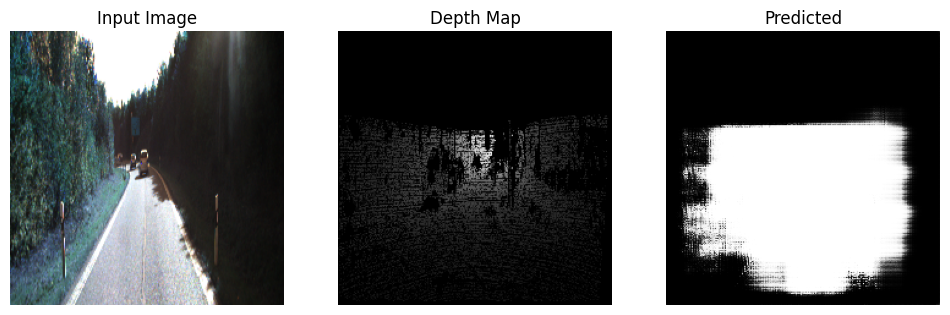

In [ ]:
ejem2=142

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()